# 4.2 Designing Adaptive Bidding Strategies in ASSUME using Reinforcement Learning

**Introduction**

This tutorial introduces the integration of **reinforcement learning (RL)** into the **ASSUME** simulation framework, with a focus on developing and deploying learning-based bidding strategies for electricity market participants.

The tutorial is designed to walk you through the essential components required to transform a conventional market participant into an RL agent. Rather than concentrating on the underlying algorithmic infrastructure—such as training loops, buffers, or learning roles—this tutorial emphasizes **how to define a bidding strategy that interfaces with the ASSUME learning backend**. You will learn how to construct observation spaces, define action mappings, and design reward functions that guide agent behavior.

Each core concept is addressed in a dedicated chapter, accompanied by exercises that allow you to apply the material directly. These hands-on tasks culminate in a final integration chapter where you will run a complete simulation and train your first learning agent.



**Tutorial Structure**

The tutorial is divided into the following chapters:

1. **ASSUME & Learning Basics**

   A conceptual overview of RL within the ASSUME framework, including actor-critic architectures, centralized training, and multi-agent design principles.

2. **Get ASSUME Running**

   Instructions for installing ASSUME and preparing your environment, whether locally or in Google Colab.

3. **Defining the Observation Space**

   Explanation and coding tasks for constructing shared and individual observations used by agents to make decisions.

4. **Action Selection and Exploration**

   How to convert actor network outputs into economically meaningful bid prices and apply exploration during training.

5. **Reward Function Design**

   Techniques for shaping agent behavior using profit- and regret-based reward signals. Includes a task to define your own reward logic.

6. **Training Your First Learning Agent**

   Integration of the previously implemented components into a complete simulation run, demonstrating end-to-end learning behavior in a market setting.



**Learning Outcomes**

By completing this tutorial, you will be able to:

* Implement RL-compatible bidding strategies within the ASSUME framework.
* Define observation inputs for learning agents.
* Map actor outputs to valid market actions and manage exploration.
* Construct reward functions that combine economic incentives with strategic signals.
* Train and evaluate a basic RL agent in a multi-agent electricity market simulation.

---

## 1. ASSUME & Learning Basics

### 1.1 The ASSUME Framework

ASSUME is a simulation framework designed for researchers, utilities, and planners to model and understand market dynamics in electricity systems. It allows for agent-based modeling of market participants in a modular and configurable environment.

The core structure of the framework consists of:

* **Markets** (on the left of the architecture diagram): Where electricity products are traded.
* **Market Participants / Units** (on the right): Each agent represents a physical or virtual unit bidding into the market.
* **Orders**: The main communication channel between units and markets.
* **Learning Agents**: Highlighted in yellow in the architecture, these are agents using RL strategies.


> The image below illustrates the high-level architecture of ASSUME. Focus on the yellow components—these are the parts involved in the learning process.

In [2]:
import os

from IPython.display import SVG, display

image_path = "assume-repo/docs/source/img/architecture.svg"
alt_image_path = "../../docs/source/img/architecture.svg"

if os.path.exists(image_path):
    display(SVG(image_path))
elif os.path.exists(alt_image_path):
    display(SVG(alt_image_path))

### 1.2 Introduction to Learning in ASSUME

The current implementation of RL in ASSUME models electricity markets as **partially observable Markov games**, allowing multiple agents to operate under individual observations and reward structures.

If you are unfamiliar with RL, refer to the following links for background material:

* [Reinforcement Learning Overview](https://assume.readthedocs.io/en/latest/learning.html)
* [Reinforcement Learning Algorithms](https://assume.readthedocs.io/en/latest/learning_algorithm.html)

**Central Concepts:**

* **Policy**: The strategy used by an agent to select actions based on observations.
* **Actor-Critic Architecture**: A method where the "actor" chooses actions and the "critic" evaluates them.
* **Learning Strategy**: Defines how a unit transforms observations into bids using a trainable model.
* **Step Functions**: The typical RL cycle of Observe → Act → Reward → Update is split across several methods in ASSUME, as described in Section 3.


### 1.3 Single-Agent RL

In a single-agent setup, the agent attempts to maximize its reward over time by learning from interaction with the environment. It does so by making multiple steps in the environment. In RL, each interaction step includes:

1. **Observation** of the current state.
2. **Action** selection based on policy.
3. **Reward** from the environment.
4. **Policy Update** to improve behavior.

In ASSUME, this step cycle is modularized:

| RL Step | Implemented via                                            | Description                                  |
| ------- | ---------------------------------------------------------- | -------------------------------------------- |
| Step 1  | `create_observation()` and `get_individual_observations()` | Constructs the observation vector.           |
| Step 2  | `calculate_bids()` and `get_actions()`                     | Maps observations to bid prices.             |
| Step 3  | `calculate_reward()`                                       | Computes the reward signal.                  |
| Step 4  | Handled by the learning role                               | Updates model and manages the replay buffer. |


**Actor-Critic Structure:**
To increase learning stability actor critic methods ar ecommonly used. They divide the tasks in the following way:

* **Actor**: Learns a deterministic policy for choosing actions. Uses policy gradient methods to maximize expected reward.
* **Critic**: Learns a value function using Temporal Difference (TD) learning. Provides feedback to the actor based on action quality.


### 1.4 Multi-Agent RL

Real-world electricity markets involve multiple agents acting simultaneously, which introduces interdependencies and non-stationarity. As a result, multi-agent learning requires additional considerations.

**Challenges:**

* Actions by one agent influence the environment experienced by others.
* The state transitions and rewards become non-stationary.

**Solution: Centralized Training with Decentralized Execution (CTDE)**

To address these challenges, ASSUME employs the **Multi-Agent Twin Delayed Deep Deterministic Policy Gradient (MATD3)** framework with CTDE:

* **Centralized Training**: A critic with access to all agents' states and actions is used during training to stabilize learning. Note the cirtic is onyl there to update the actor network, so it is only necessary while training. 
* **Decentralized Execution**: During simulation, the actual actor of each agent relies only on its own observations and learned policy.

Each agent trains two critic networks to mitigate overestimation bias, uses target noise for robustness, and relies on deterministic policy gradients for the actor update.

---

## 2. Get ASSUME Running

This chapter walks you through setting up the ASSUME framework in your environment and preparing the required input files. At the end, you will confirm that the installation was successful and ready for use.


### 2.1 Installation

#### In Google Colab

Google Colab already includes most scientific computing libraries (e.g., `numpy`, `torch`). You only need to install the ASSUME core framework:

In [3]:
# Only run this cell if you are using Google Colab
import importlib.util

IN_COLAB = importlib.util.find_spec("google.colab") is not None

if IN_COLAB:
    !pip install assume-framework

> **Note**: After installation, **Colab may prompt you to restart the session** due to dependency changes.
> To do so, click **"Runtime" → "Restart session..."** in the menu bar, then re-run the cells above.


#### On Your Local Machine

To install ASSUME with all learning-related dependencies, run the following in your terminal:

```bash
pip install 'assume-framework[learning]'
```

This will install the simulation framework and the packages required for RL.



### 2.2 Repository Setup

To access predefined simulation scenarios, clone the ASSUME repository (Colab only):

In [4]:
# Only run this cell if you are using Google Colab
if IN_COLAB:
    !git clone --depth=1 https://github.com/assume-framework/assume.git assume-repo

> Local users may skip this step if input files are already available in the project directory.


### 2.3 Input Path Configuration

We define the path to input files depending on whether you're in Colab or working locally. This variable will be used to load configuration and scenario files throughout the tutorial.

In [5]:
colab_inputs_path = "assume-repo/examples/inputs"
local_inputs_path = "../inputs"

inputs_path = colab_inputs_path if IN_COLAB else local_inputs_path

### 2.4 Installation Check

Use the following cell to ensure the installation was successful and that essential components are available. This test ensures that the simulation engine and RL strategy base class are accessible before continuing.

In [6]:
try:
    from assume import World
    from assume.strategies.learning_strategies import BaseLearningStrategy

    print("✅ ASSUME framework is installed and functional.")
except ImportError as e:
    print("❌ Failed to import essential components:", e)
    print(
        "Please review the installation instructions and ensure all dependencies are installed."
    )

✅ ASSUME framework is installed and functional.


### 2.5 Limitations in Colab

Colab does not support Docker, so dashboard visualizations included in some ASSUME workflows will not be available. However, simulation runs and RL training can still be fully executed.

* In **Colab**: Training and basic plotting are supported.
* In **Local environments with Docker**: Full access, including dashboards.


### 2.6 Core Imports

In this section, we import the core modules that will be used throughout the tutorial. Each import is explained to clarify its role.

In [7]:
# Standard Python modules
import logging  # For logging messages during simulation and debugging
from datetime import timedelta  # To handle market time resolutions (e.g., hourly steps)

import matplotlib.pyplot as plt

# Scientific and data processing libraries
import numpy as np  # Numerical operations and array handling
import pandas as pd  # Data manipulation and analysis
import yaml  # Parsing YAML configuration files

# Database and visualization libraries
from sqlalchemy import create_engine

# ASSUME framework components
from assume import World  # Core simulation container that manages markets and agents
from assume.scenario.loader_csv import (  # Functions to load and execute scenarios
    load_scenario_folder,
    run_learning,
)
from assume.strategies.learning_strategies import (
    BaseLearningStrategy,  # Abstract base for RL bidding strategies
)

These imports are used for:

* Defining RL bidding strategies.
* Managing input/output data.
* Executing and analyzing simulations.


At this point, you are ready to begin building your RL bidding agent. In the next chapter, we will define how agents perceive the market by constructing their **observation vectors**.

---

## 3. Defining the Observation Space

In this chapter, you will define what information your RL agent perceives about the environment and itself at each decision point. This is a critical component of the agent’s behavior, as the observation vector forms the basis for all future actions and learning.


| RL Step | Implemented via                                            | Description                                  |
| ------- | ---------------------------------------------------------- | -------------------------------------------- |
| **Step 1**  | `create_observation()` and `get_individual_observations()` | Constructs the observation vector.           |

### 3.2 Observation Structure in ASSUME

Observations are composed of two parts:

**1. Global Observations**

These are shared across all agents and constructed by the base class method `create_observation()`. They include:

* **Forecasted residual load** over the foresight horizon.
* **Forecasted market price** over the foresight horizon.
* **Historical market price** over a specified window.

> These are normalized by maximum demand and maximum bid price for stability.
> These values are generated by a forecasting role and made available to all agents before each market cycle.

for this tutorial **you do not need to modify this part.** However, if you want to equip new units types with learning or expand the simulation by new concepts, additional global information might be needed. 

**2. Individual Observations**

These are unit-specific and must be implemented by you. The purpose is to provide the agent with private, operational information that may help improve bidding decisions. Each agent appends this information to the end of the shared observation vector.

This is done via the method `get_individual_observations(unit, start)`.


### 3.3 Defining the Strategy Class and Constructor

To enable learning, we define a custom class that extends `BaseLearningStrategy` and initializes key dimensions for the model:

In [8]:
class SingleBidLearningStrategy(BaseLearningStrategy):
    """
    A simple reinforcement learning bidding strategy.
    """

    def __init__(self, *args, **kwargs):
        obs_dim = kwargs.pop("obs_dim", 38)  # Forecasts + history + individual values
        act_dim = kwargs.pop("act_dim", 1)  # One action: bid price
        unique_obs_dim = kwargs.pop("unique_obs_dim", 2)  # Number of individual obs

        super().__init__(
            obs_dim=obs_dim,
            act_dim=act_dim,
            unique_obs_dim=unique_obs_dim,
            *args,
            **kwargs,
        )

        # Forecast horizon (in timesteps) used for market and residual load forecasts
        self.foresight = 12

### 3.4 Exercise 1: Define Individual Observations

Now you will implement the following method:

In [9]:
# we define the class again and inherit from the initial class just to add the additional method to the original class
# this is a workaround to have different methods of the class in different cells
# which is good for the purpose of this tutorial
# however, you should have all functions in a single class when using this example in .py files


class SingleBidLearningStrategy(SingleBidLearningStrategy):
    def get_individual_observations(self, unit, start):
        """
        Define custom unit-specific observations for the RL agent.

        Parameters
        ----------
        unit : SupportsMinMax
            The unit representing the power plant.
        start : datetime.datetime
            Start time of the market product.

        Returns
        -------
        np.ndarray
            Normalized 1D array of individual observations.
        """
        # Your implementation here

This method must return a NumPy array of length `unique_obs_dim`.


**What Should Be in an Individual Observation?**

The key principle is to include values that are:

* Known **only** to the unit itself.
* Relevant for market bidding.
* Reflective of the unit’s technical or economic constraints.

Here are some good candidate features and how to compute them using ASSUME:

| Feature                             | Description                                    | Access via                                            |
| ----------------------------------- | ---------------------------------------------- | ----------------------------------------------------- |
| **Current output**                  | How much power the unit is currently producing | `unit.get_output_before(start)`                       |
| **Marginal cost**                   | Cost to produce current output                 | `unit.calculate_marginal_cost(start, current_volume)` |
| **Max capacity**                    | Upper generation limit                         | `unit.max_power`                                      |
| **Start-up/shut-down state**        | May be encoded in dispatch history             | infer from `unit.get_output_before(start)`            |
| **Ramp limit**                      | Maximum change in output allowed               | `unit.ramp_up`, `unit.ramp_down`                      |
| **Efficiency or fuel cost factors** | If applicable                                  | custom attributes per unit model                      |

**Solution**

In [10]:
# we define the class again and inherit from the initial class just to add the additional method to the original class
# this is a workaround to have different methods of the class in different cells
# which is good for the purpose of this tutorial
# however, you should have all functions in a single class when using this example in .py files


class SingleBidLearningStrategy(SingleBidLearningStrategy):
    def get_individual_observations(self, unit, start):
        # --- Current volume & marginal cost ---
        current_volume = unit.get_output_before(start)
        current_costs = unit.calculate_marginal_cost(start, current_volume)

        scaled_total_dispatch = current_volume / unit.max_power
        scaled_marginal_cost = current_costs / self.max_bid_price

        individual_observations = np.array(
            [scaled_total_dispatch, scaled_marginal_cost]
        )

        return individual_observations

### 3.5 Summary

* Observations in ASSUME combine **shared global forecasts** and **custom individual data**.
* The base class handles forecasted residual load and price, as well as historical price signals.
* These observations directly affect agent behavior and learning convergence—thoughtful design matters.


In the next chapter, you will define **how the agent selects actions** based on its observations, and how **exploration** is introduced during initial training to populate the learning buffer.

---

## 4. Action Selection and Exploration

Once an observation is formed, the next step is for the agent to decide how to act. In this context, the **action** determines the **bid price** submitted by the agent to the electricity market.


This chapter focuses on how actions are derived from the agent’s policy and how exploration is handled—especially during the early training phase when experience is sparse.

### 4.1 Action Selection in RL

In RL, the **policy** defines the agent’s behavior: it maps observations to actions. In the actor-critic architecture used by ASSUME, this policy is represented by the **actor neural network**.

However, to enable **exploration**, especially in the early stages of training, agents must not always follow the policy exactly. They need to try out a variety of actions—even suboptimal ones—to collect diverse experiences and learn effectively.

This is done by **adding noise** to the actions suggested by the policy network.

> Note: The implementation of noise we present here is specific to the used algorithm **MADDPG**. Other Algorthms such as the PPO will use a different mechanism for exploration. 

### 4.2 Understanding `get_actions()`

The method `get_actions(next_observation)` in `BaseLearningStrategy` defines how actions are computed in different modes of operation.

Here is a simplified overview of the logic:

```python
def get_actions(self, next_observation):
    if self.learning_mode and not self.evaluation_mode:
        if self.collect_initial_experience_mode:
            # Initial exploration: use pure noise as action
            noise = ...
            curr_action = noise
        else:
            # Regular exploration: add noise to policy output
            curr_action = self.actor(next_observation).detach()
            noise = self.action_noise.noise(...)
            curr_action += noise
    else:
        # Evaluation or deterministic policy use
        curr_action = self.actor(next_observation).detach()
        noise = zeros_like(curr_action)

    return curr_action, noise
```

**Modes of Operation:**

* `learning_mode`: Indicates that the agent is being trained (vs. used for evaluation).
* `evaluation_mode`: Disables noise; used to assess performance of a learned policy.
* `collect_initial_experience_mode`: Special sub-phase during early episodes where we rely heavily on **randomized exploration** to populate the replay buffer with diverse samples.



### 4.3 What Is Initial Experience Collection Mode?

The **initial experience collection mode** refers to the first `N` episodes of training where agents fill their learning buffers **purely through exploration**. No learned policy is used at this stage.

The purpose is to:

* Cover a broad region of the action space.
* Enable agents to observe the outcome of many different bidding decisions.

By default, the action in this mode is **pure noise**, sampled from a Gaussian distribution.


### 4.4 Improving Exploration with Prior Knowledge

While random actions help explore broadly, we can use **economic and technical knowledge** to make exploration more guided.

**What would be a good starting point for a conventional generator?** Exploring in a region around this value is far more productive than exploring arbitrarily.

Thus, instead of using random noise alone, we can **shift the noisy action** around a known good starting point so that exploration begins from a plausible economic baseline.

### 4.5 Exercise 2: Guided Exploration

Your task is to modify the `get_actions()` method to implement a better initial exploration mechanism.

**Objective:**

During the `collect_initial_experience_mode`, instead of using pure noise, base the exploration around a known signal from the observation vector.

In [11]:
# we define the class again and inherit from the initial class just to add the additional method to the original class
# this is a workaround to have different methods of the class in different cells
# which is good for the purpose of this tutorial
# however, you should have all functions in a single class when using this example in .py files


class SingleBidLearningStrategy(SingleBidLearningStrategy):
    def get_actions(self, next_observation):
        """
        Compute actions based on the current observation, optionally applying noise for exploration.

        Args
        ----
        next_observation : torch.Tensor
            The current observation, where the last element is assumed to be the marginal cost.

        Returns
        -------
        tuple of torch.Tensor
            - Action (with or without noise)
            - The applied noise
        """
        # Get the base action and associated noise from the parent implementation
        curr_action, noise = super().get_actions(next_observation)

        if self.learning_mode and not self.evaluation_mode:
            if self.collect_initial_experience_mode:
                # TODO: extract a relevant reference value from next_observation
                # TODO: shift the noisy action around this value
                pass  # replace this with your implementation

        return curr_action, noise

In [12]:
# Solution Exercise 2: Improve Initial Exploration

# we define the class again and inherit from the initial class just to add the additional method to the original class
# this is a workaround to have different methods of the class in different cells
# which is good for the purpose of this tutorial
# however, you should have all functions in a single class when using this example in .py files


class SingleBidLearningStrategy(SingleBidLearningStrategy):
    def get_actions(self, next_observation):
        # Get the base action and associated noise from the parent implementation
        curr_action, noise = super().get_actions(next_observation)

        if self.learning_mode and not self.evaluation_mode:
            if self.collect_initial_experience_mode:
                # Assumes last dimension of the observation corresponds to marginal cost
                marginal_cost = next_observation[-1].detach()
                # Center the noisy action around marginal cost
                curr_action += marginal_cost

        return curr_action, noise

This strategy anchors exploration to a meaningful economic quantity, improving the quality of early experiences and accelerating convergence.


### 4.6 Summary

* The `get_actions()` method controls how agents choose actions under different modes.
* During training, actions include noise to enable exploration.
* Initial exploration can be enhanced by guiding actions toward domain-relevant baselines (e.g., marginal cost).
* You implemented a strategy to **anchor exploration** using part of the observation vector.

In the next chapter, we will define the **reward function**, where you'll decide how to quantify success and failure in the agent’s bidding behavior.

---

## 5 From Observation to Action to Bids

In the previous chapters, we explored how an agent perceives its environment through observations and how it selects actions using its policy, optionally enriched with exploration noise. In this short chapter, we show how these two steps come together inside the `calculate_bids()` method.


### 5.1 The Role of `calculate_bids()`

The `calculate_bids()` method defines how a market participant formulates its bid at each market interval. It brings together two crucial operations:

1. **Generating Observations**
   Calls `create_observation()` to construct the full input vector (including both global and individual components).

2. **Choosing an Action**
   Passes the observation to `get_actions()`, which invokes the actor network (and optionally adds noise) to return an action vector.

This forms the agent’s internal decision pipeline.

### 5.2 Action Normalization and Scaling

The neural network policy outputs **normalized actions**—typically bounded in the range $[-1, 1]$. To convert these to meaningful bid prices, the raw action is scaled by a predefined constant:

```python
bid_price = actions[0] * self.max_bid_price
```

For example, if `self.max_bid_price = 100`, the resulting bid prices will fall between $-100$ and $100$. This reflects a design choice that bounds the agent’s economic behavior in a defined domain.

By modifying `max_bid_price` in the learning config, you directly influence the economic aggressiveness of the policy.


### 5.3 Bid Structure

Each bid submitted to the market follows a defined structure, encapsulated as a dictionary:

```python
{
    "start_time": start,
    "end_time": end,
    "price": bid_price,
    "volume": max_power,
    "node": unit.node,
}
```

Key aspects:

* **price**: Determined from the scaled output of the policy.
* **volume**: Set to the full technical capacity of the unit.
* **node**: Locational identifier (used for zonal/nodal pricing and congestion modeling).

Note that `max_power` is **positive**, as this strategy models a generator offering energy. For a **consumer or demand bid**, the volume would be **negative** to reflect load withdrawal.


### 5.4 Why We Store Everything in `unit.outputs`

The outputs of the bidding process are stored in two places:

* `unit.outputs["rl_observations"]` and `["rl_actions"]`:
  Stored as lists to be written into the replay buffer for learning.

* `unit.outputs["actions"]` and `["exploration_noise"]`:
  Stored as `pandas.Series` for compatibility with the unit’s internal logging and database structure.

This dual storage ensures that both the simulation engine and the learning backend have access to the relevant data.


### 5.5 Controlling Action Dimensions

By changing the `act_dim` in the strategy constructor, you can control the number of outputs returned by the actor network:

```python
act_dim = kwargs.pop("act_dim", 1)
```

This allows for richer bidding logic. For instance:

* 1 action: Bid price for total capacity.
* 2 actions: Bid prices for flexible vs. inflexible portions.
* 3 actions: Add directionality or reserve offers.

However, it is important to note that **RL performance deteriorates with high-dimensional action spaces**, especially in continuous domains.

If you decide to increase `act_dim`, ensure that your `calculate_bids()` method is updated accordingly to interpret and transform all action elements correctly.


### 5.6 Full Code Implementation

Here is the complete `calculate_bids()` implementation:

In [13]:
# we define the class again and inherit from the initial class just to add the additional method to the original class
# this is a workaround to have different methods of the class in different cells
# which is good for the purpose of this tutorial
# however, you should have all functions in a single class when using this example in .py files


class SingleBidLearningStrategy(SingleBidLearningStrategy):
    def calculate_bids(self, unit, market_config, product_tuples, **kwargs):
        start = product_tuples[0][0]
        end = product_tuples[0][1]

        # get technical bounds for the unit output from the unit
        _, max_power = unit.calculate_min_max_power(start, end)
        max_power = max_power[0]

        # =============================================================================
        # 1. Get the Observations, which are the basis of the action decision
        # =============================================================================
        next_observation = self.create_observation(
            unit=unit,
            market_id=market_config.market_id,
            start=start,
        )

        # =============================================================================
        # 2. Get the Actions, based on the observations
        # =============================================================================
        actions, noise = self.get_actions(next_observation)

        # =============================================================================
        # 3. Transform Actions into bids
        # =============================================================================
        # actions are in the range [-1,1], we need to transform them into actual bids
        # we can use our domain knowledge to guide the bid formulation
        bid_price = actions[0] * self.max_bid_price

        # actually formulate bids in orderbook format
        bids = [
            {
                "start_time": start,
                "end_time": end,
                "price": bid_price,
                "volume": max_power,
                "node": unit.node,
            },
        ]

        # store results in unit outputs as lists to be written to the buffer for learning
        unit.outputs["rl_observations"].append(next_observation)
        unit.outputs["rl_actions"].append(actions)

        # store results in unit outputs as series to be written to the database by the unit operator
        unit.outputs["actions"].at[start] = actions
        unit.outputs["exploration_noise"].at[start] = noise

        return bids

In the next chapter, we will define how to compute the **reward** associated with each bid outcome, which completes the agent’s learning cycle.

---

## 6. Reward Function Design

The reward function is the **central learning signal** in any RL environment. It defines the objective the agent is trying to maximize and serves as the only feedback mechanism from the environment to the agent.

In market-based simulations such as ASSUME, designing the reward function is a delicate balance between:

* Capturing **realistic economic goals** (e.g., profit maximization),
* Enabling **learning stability and convergence**, and
* Leaving room for the agent to **discover unexpected, valid strategies**.


### 6.1 The Role of Rewards in Learning

A well-designed reward should offer meaningful feedback while allowing the agent space to **explore and invent novel solutions**. It’s tempting to hard-code your preferred behavior into the reward function—but doing so often leads to overfitting or brittle learning.

Instead, the reward should express what success looks like in **economic or physical terms**, and allow the policy to optimize toward it in its own way.


### 6.2 When Is the Reward Computed?

In ASSUME, the reward is computed **after the market clears**, in the `calculate_reward()` method. At this point, the agent receives information about:

* Which portion of its bid was accepted,
* At what price,
* And what operational costs it incurred.

This allows us to calculate realized **profit**, which is the most direct economic reward signal.


### 6.3 Exercise 3: Implement Profit-Based Reward

Your first task is to implement a profit-based reward. This is **mandatory**.

Use the following simplified formula:

$$
\pi_{i,t} =
\begin{cases}
P^\text{conf}_{i,t} \cdot (M_t - mc_{i,t}) \cdot dt & \text{if } P^\text{conf}_{i,t} \geq P^{\min}_i \\
0 & \text{otherwise}
\end{cases}
$$

Where:

* $P^\text{conf}$: Confirmed volume (accepted by market),
* $M_t$: Market clearing price,
* $mc_{i,t}$: Marginal generation cost,
* $dt$: Time resolution in hours.

You can access these quantities via:

```python
accepted_volume = order["accepted_volume"]
market_clearing_price = order["accepted_price"]
marginal_cost = unit.calculate_marginal_cost(start, unit.outputs[marketconfig.product_type].at[start])
```

Use the duration in hours:

```python
duration = (end - start) / timedelta(hours=1)
```

### 6.4 Exercise 3 (optional): Thinking Beyond Profit

While profit is a good starting point, agents trained solely on profit may struggle in competitive environments or when there is limited dispatch. In real-world operations, generators also consider **missed opportunities**—what could have been earned but wasn’t due to poor bidding or conservative behavior.

> What other signal could guide the agent to bid more strategically?
>
> What do real power plants look at when evaluating their bidding success—even when they were not dispatched?

Use your economic intuition or power system experience to answer this.

In [14]:
# we define the class again and inherit from the initial class just to add the additional method to the original class
# this is a workaround to have different methods of the class in different cells
# which is good for the purpose of this tutorial
# however, you should have all functions in a single class when using this example in .py files


class SingleBidLearningStrategy(SingleBidLearningStrategy):
    def calculate_reward(self, unit, marketconfig, orderbook):
        """
        Reward function: implement profit and (optionally) opportunity cost.

        Instructions:
        - Fill in the lines marked as YOUR CODE.
        - Compute profit as the primary reward signal.
        - Optionally define the opportunity cost as a regret term.
        """

        start = orderbook[0]["start_time"]
        end = orderbook[0]["end_time"]
        duration = (end - start) / timedelta(hours=1)
        end_excl = end - unit.index.freq

        order = orderbook[0]
        market_clearing_price = None  # YOUR CODE HERE
        accepted_volume = None  # YOUR CODE HERE

        marginal_cost = unit.calculate_marginal_cost(
            start, unit.outputs[marketconfig.product_type].at[start]
        )

        # === Required: compute profit ===
        order_income = None  # YOUR CODE HERE
        order_cost = None  # YOUR CODE HERE
        order_profit = None  # YOUR CODE HERE

        # === Optional: compute opportunity cost ===
        opportunity_cost = None  # YOUR CODE HERE

        regret_scale = 0.1 if accepted_volume > unit.min_power else 0.5

        # === Normalize reward to ~[-1, 1] ===
        scaling = 1 / (self.max_bid_price * unit.max_power)
        reward = scaling * (order_profit - regret_scale * opportunity_cost)

        unit.outputs["profit"].loc[start:end_excl] = order_profit
        unit.outputs["reward"].loc[start:end_excl] = reward
        unit.outputs["regret"].loc[start:end_excl] = regret_scale * opportunity_cost
        unit.outputs["total_costs"].loc[start:end_excl] = order_cost
        unit.outputs["rl_rewards"].append(reward)

**Hint Optional Extension: Opportunity Cost**

The concept of **opportunity cost** captures the **lost profit** from unused capacity. If the market price exceeds marginal cost and the unit wasn't dispatched fully, that represents a missed opportunity.

This can be used as a **regret term** to penalize under-utilization of profitable bids.

Mathematically:

$$
cm_{i,t} = \max\left[(P^{\max}_i - P^\text{conf}_{i,t}) \cdot (M_t - mc_{i,t}) \cdot dt, 0\right]
$$

A good reward function combines profit and opportunity cost, allowing agents to learn from both actual performance and missed potential.



### 6.6 Reward Scaling and Learning Stability

Scaling the reward to a **narrow and consistent range** is crucial for stable RL. This is particularly important in continuous-action settings like bidding, where one overly large reward spike can skew the policy updates significantly.

**1. Why scale?**

* Stabilizes gradients during actor-critic training.
* Makes different time steps comparable in magnitude.
* Prevents the agent from overfitting to rare but extreme events.

**2. What can go wrong?**

If your scaling factor is too small:

* Rewards become indistinguishable from noise.

If your scaling factor is too large:

* A single high-reward event (e.g., bidding into a rare price spike) can **dominate learning**,
  making the agent try to reproduce that event rather than learn a general policy.

> **Tip**: Use conservative scaling based on maximum realistic bid × capacity:

```python
scaling = 1 / (self.max_bid_price * unit.max_power)
```

**3 Recommended Practice**

Before committing to training:

* **Plot the distribution of rewards** across time steps for a few sample runs.
* Check for outliers, saturation, or skewness.
* If needed, adjust `scaling` or cap outliers in reward postprocessing.

This diagnostic step can save hours of failed training runs.


**Exercise 3 Solution**

In [15]:
# Solution Exercise 3: Implement Reward Function

# we define the class again and inherit from the initial class just to add the additional method to the original class
# this is a workaround to have different methods of the class in different cells
# which is good for the purpose of this tutorial
# however, you should have all functions in a single class when using this example in .py files


class SingleBidLearningStrategy(SingleBidLearningStrategy):
    def calculate_reward(
        self,
        unit,
        marketconfig,
        orderbook,
    ):
        """
        Calculates the reward for the unit based on profits, costs, and opportunity costs from market transactions.

        The reward is computed by combining the following:
        - **Profit**: Income from accepted bids minus marginal and start-up costs.
        - **Opportunity Cost**: Penalty for underutilizing capacity, calculated as potential lost income.
        - **Regret Term**: A scaled regret term penalizes high opportunity costs to guide effective bidding.

        The reward is scaled and stored along with other outputs in the unit’s data to support learning.
        """

        start = orderbook[0]["start_time"]
        end = orderbook[0]["end_time"]
        duration = (end - start) / timedelta(hours=1)

        # `end_excl` marks the last product's start time by subtracting one frequency interval.
        end_excl = end - unit.index.freq

        order = orderbook[0]  # Assuming a single order for simplicity

        market_clearing_price = order["accepted_price"]
        accepted_volume = order["accepted_volume"]

        # Depending on how the unit calculates marginal costs, retrieve cost values.
        marginal_cost = unit.calculate_marginal_cost(
            start, unit.outputs[marketconfig.product_type].at[start]
        )

        # Calculate profit as income minus operational cost for this event.
        order_income = market_clearing_price * accepted_volume * duration
        order_cost = marginal_cost * accepted_volume * duration

        # Accumulate income and operational cost for all orders.
        order_profit = order_income - order_cost

        # Opportunity cost: The income lost due to not operating at full capacity.
        opportunity_cost = (
            (market_clearing_price - marginal_cost)
            * (unit.max_power - accepted_volume)
            * duration
        )

        # If opportunity cost is negative, no income was lost, so we set it to zero.
        opportunity_cost = max(opportunity_cost, 0)

        # Dynamic regret scaling:
        # - If accepted volume is positive, apply lower regret (0.1) to avoid punishment for being on the edge of the merit order.
        # - If no dispatch happens, apply higher regret (0.5) to discourage idle behavior, if it could have been profitable.
        regret_scale = 0.1 if accepted_volume > unit.min_power else 0.5

        # --------------------
        # 4.1 Calculate Reward
        # Instead of directly setting reward = profit, we incorporate a regret term (opportunity cost penalty).
        # This guides the agent toward strategies that maximize accepted bids while minimizing lost opportunities.

        # scaling factor to normalize the reward to the range [-1,1]
        scaling = 1 / (self.max_bid_price * unit.max_power)

        reward = scaling * (order_profit - regret_scale * opportunity_cost)

        # Store results in unit outputs, which are later written to the database by the unit operator.
        unit.outputs["profit"].loc[start:end_excl] = order_profit
        unit.outputs["reward"].loc[start:end_excl] = reward
        unit.outputs["regret"].loc[start:end_excl] = regret_scale * opportunity_cost
        unit.outputs["total_costs"].loc[start:end_excl] = order_cost

        unit.outputs["rl_rewards"].append(reward)

### 6.7 Summary

* The reward function is the core signal guiding agent learning—design it carefully.
* Start with **profit** as the primary reward.
* Consider adding **opportunity cost** as a regret penalty to improve bidding behavior.
* Always **normalize** your reward to maintain training stability.
* Analyze your reward distribution empirically before training large-scale agents.

In the next chapter, we will bring together all the components—observation, action, and reward—and simulate a full training run using your custom learning strategy.

---

## 7: Training and Evaluating Your First Learning Agent

You have now implemented all essential components of a learning bidding strategy in ASSUME:

* Observations
* Actions and exploration
* Reward function

In this chapter, you will connect your strategy to a simulation scenario, configure the learning algorithm, and evaluate the agent’s training progress.


### 7.1 Load and Inspect the Learning Configuration

Each simulation scenario in ASSUME has an associated YAML configuration file. This file contains the **learning configuration**, which determines how the RL algorithm is executed.

In [16]:
scenario = "base"

# Read the YAML file
with open(f"{inputs_path}/example_02a/config.yaml") as file:
    config = yaml.safe_load(file)

# Print the learning config
print(f"Learning config for scenario '{scenario}':")
display(config[scenario]["learning_config"])

Learning config for scenario 'base':


{'continue_learning': False,
 'trained_policies_save_path': None,
 'trained_policies_load_path': None,
 'max_bid_price': 100,
 'algorithm': 'matd3',
 'learning_rate': 0.001,
 'training_episodes': 100,
 'episodes_collecting_initial_experience': 5,
 'train_freq': '100h',
 'gradient_steps': 10,
 'batch_size': 128,
 'gamma': 0.99,
 'device': 'cpu',
 'action_noise_schedule': 'linear',
 'noise_sigma': 0.1,
 'noise_scale': 1,
 'noise_dt': 1,
 'validation_episodes_interval': 5}

**Explanation of Learning Configuration Parameters**

| Parameter                                     | Description                                                                           |
| --------------------------------------------- | ------------------------------------------------------------------------------------- |
| **continue\_learning**                        | If `True`, resumes training from saved policy checkpoints.                            |
| **trained\_policies\_save\_path**             | File path where trained policies will be saved.                                       |
| **trained\_policies\_load\_path**             | Path to pre-trained policies to load.                                                 |
| **max\_bid\_price**                           | Used to scale action outputs to economic bid prices.                                  |
| **algorithm**                                 | Learning algorithm used (e.g., `matd3` for multi-agent TD3).                          |
| **learning\_rate**                            | Step size for policy and critic updates.                                              |
| **training\_episodes**                        | Number of simulation episodes (repetitions of the time horizon) used for training.    |
| **episodes\_collecting\_initial\_experience** | Number of episodes during which agents collect experience using guided exploration.   |
| **train\_freq**                               | Time between training updates, e.g., `'100h'` means update every 100 simulated hours. |
| **gradient\_steps**                           | Number of gradient descent steps per update.                                          |
| **batch\_size**                               | Size of experience batch used for training.                                           |
| **gamma**                                     | Discount factor for future rewards ($0 < \gamma \leq 1$).                             |
| **device**                                    | `"cpu"` or `"cuda"` depending on hardware.                                            |
| **action\_noise\_schedule**                   | How the action noise evolves over time (`linear`, `constant`, etc.).                  |
| **noise\_sigma**                              | Standard deviation of exploration noise.                                              |
| **noise\_scale**                              | Global multiplier for noise.                                                          |
| **noise\_dt**                                 | Discretization interval for noise time series.                                        |
| **validation\_episodes\_interval**            | How often (in episodes) to evaluate the current policy without exploration.           |



### 7.2 Run the Simulation and Train the Agent

The simulation environment and learning strategy are connected and executed as follows:

In [ ]:
log = logging.getLogger(__name__)
csv_path = "outputs"
os.makedirs("local_db", exist_ok=True)

if __name__ == "__main__":
    db_uri = "sqlite:///local_db/assume_db.db"

    scenario = "example_02a"
    study_case = "base"

    # 1. Create simulation world
    world = World(database_uri=db_uri, export_csv_path=csv_path)

    # 2. Register your learning strategy
    world.bidding_strategies["pp_learning"] = SingleBidLearningStrategy

    # 3. Load scenario and case
    load_scenario_folder(
        world,
        inputs_path=inputs_path,
        scenario=scenario,
        study_case=study_case,
    )

    # 4. Run the training phase
    if world.learning_config.get("learning_mode", False):
        run_learning(world)

    # 5. Execute final evaluation run (no exploration)
    world.run()

INFO:assume.world:Connected to the database
INFO:assume.scenario.loader_csv:Input files path: ../inputs/example_02a
INFO:assume.scenario.loader_csv:Study case: base
INFO:assume.scenario.loader_csv:Simulation ID: example_02a_base
INFO:assume.scenario.loader_csv:storage_units not found. Returning None
INFO:assume.scenario.loader_csv:exchange_units not found. Returning None
INFO:assume.scenario.loader_csv:industrial_dsm_units not found. Returning None
INFO:assume.scenario.loader_csv:residential_dsm_units not found. Returning None
INFO:assume.scenario.loader_csv:forecasts_df not found. Returning None
INFO:assume.scenario.loader_csv:Downsampling demand_df successful.
INFO:assume.scenario.loader_csv:exchanges_df not found. Returning None
INFO:assume.scenario.loader_csv:availability_df not found. Returning None
INFO:assume.scenario.loader_csv:buses not found. Returning None
INFO:assume.scenario.loader_csv:lines not found. Returning None
INFO:assume.scenario.loader_csv:Adding markets
INFO:assu

Training Episode 1 2019-03-30 23:00:00: 100%|█████████▉| 2588401.0/2592000 [00:02<00:00, 866369.04it/s]
Training Episode 2 2019-03-30 23:00:00: 100%|█████████▉| 2588401.0/2592000 [00:02<00:00, 918526.44it/s]
Training Episode 3 2019-03-30 23:00:00: 100%|█████████▉| 2588401.0/2592000 [00:03<00:00, 771529.58it/s]
Training Episode 4 2019-03-30 23:00:00: 100%|█████████▉| 2588401.0/2592000 [00:03<00:00, 858081.23it/s]
Training Episode 5 2019-03-30 23:00:00: 100%|█████████▉| 2588401.0/2592000 [00:02<00:00, 930371.92it/s]
Training Episode 6 2019-03-30 23:00:00: 100%|█████████▉| 2588401.0/2592000 [00:05<00:00, 477818.22it/s]
Training Episode 7 2019-03-30 23:00:00: 100%|█████████▉| 2588401.0/2592000 [00:05<00:00, 515518.38it/s]
Training Episode 8 2019-03-30 23:00:00: 100%|█████████▉| 2588401.0/2592000 [00:05<00:00, 515979.34it/s]
Training Episode 9 2019-03-30 23:00:00: 100%|█████████▉| 2588401.0/2592000 [00:05<00:00, 494796.63it/s]
Training Episode 10 2019-03-30 23:00:00: 100%|█████████▉| 258840

INFO:assume.reinforcement_learning.learning_role:New best policy saved, episode: 1, metric='avg_reward', value=-87.90


Training Episode 11 2019-03-30 23:00:00: 100%|█████████▉| 2588401.0/2592000 [00:05<00:00, 463667.77it/s]
Training Episode 12 2019-03-30 23:00:00: 100%|█████████▉| 2588401.0/2592000 [00:05<00:00, 499539.51it/s]
Training Episode 13 2019-03-30 23:00:00: 100%|█████████▉| 2588401.0/2592000 [00:05<00:00, 489412.81it/s]
Training Episode 14 2019-03-30 23:00:00: 100%|█████████▉| 2588401.0/2592000 [00:05<00:00, 472741.99it/s]
Training Episode 15 2019-03-30 23:00:00: 100%|█████████▉| 2588401.0/2592000 [00:04<00:00, 545690.98it/s]
Evaluation Episode 2 2019-03-30 23:00:00: 100%|█████████▉| 2588401.0/2592000 [00:03<00:00, 807867.95it/s]


INFO:assume.reinforcement_learning.learning_role:New best policy saved, episode: 2, metric='avg_reward', value=41.46


Training Episode 16 2019-03-30 23:00:00: 100%|█████████▉| 2588401.0/2592000 [00:05<00:00, 479293.45it/s]
Training Episode 17 2019-03-30 23:00:00: 100%|█████████▉| 2588401.0/2592000 [00:05<00:00, 506515.19it/s]
Training Episode 18 2019-03-30 23:00:00: 100%|█████████▉| 2588401.0/2592000 [00:04<00:00, 531359.97it/s]
Training Episode 19 2019-03-30 23:00:00: 100%|█████████▉| 2588401.0/2592000 [00:05<00:00, 503155.56it/s]
Training Episode 20 2019-03-30 23:00:00: 100%|█████████▉| 2588401.0/2592000 [00:05<00:00, 493224.24it/s]
Evaluation Episode 3 2019-03-30 23:00:00: 100%|█████████▉| 2588401.0/2592000 [00:03<00:00, 777270.96it/s]


INFO:assume.reinforcement_learning.learning_role:New best policy saved, episode: 3, metric='avg_reward', value=47.21


Training Episode 21 2019-03-30 23:00:00: 100%|█████████▉| 2588401.0/2592000 [00:04<00:00, 530394.35it/s]
Training Episode 22 2019-03-30 23:00:00: 100%|█████████▉| 2588401.0/2592000 [00:04<00:00, 542896.44it/s]
Training Episode 23 2019-03-30 23:00:00: 100%|█████████▉| 2588401.0/2592000 [00:04<00:00, 528470.32it/s]
Training Episode 24 2019-03-30 23:00:00: 100%|█████████▉| 2588401.0/2592000 [00:05<00:00, 511748.62it/s]
Training Episode 25 2019-03-30 23:00:00: 100%|█████████▉| 2588401.0/2592000 [00:04<00:00, 529321.01it/s]
Evaluation Episode 4 2019-03-30 23:00:00: 100%|█████████▉| 2588401.0/2592000 [00:03<00:00, 745804.88it/s]


INFO:assume.reinforcement_learning.learning_role:New best policy saved, episode: 4, metric='avg_reward', value=50.89


Training Episodes:  25%|██▌       | 25/100 [02:23<08:30,  6.81s/it]

ERROR:assume.reinforcement_learning.tensorboard_logger:Unexpected error in update_tensorboard: 'dt'


Training Episodes:  26%|██▌       | 26/100 [02:26<07:08,  5.78s/it]--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\tg3533\AppData\Local\miniconda3\envs\assume-framework\Lib\logging\__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\tg3533\AppData\Local\miniconda3\envs\assume-framework\Lib\logging\__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "c:\Users\tg3533\AppData\Local\miniconda3\envs\assume-framework\Lib\logging\__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\tg3533\AppData\Local\miniconda3\envs\assume-framework\Lib\logging\__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen r

ERROR:assume.reinforcement_learning.tensorboard_logger:Unexpected error in update_tensorboard: 'dt'


Training Episodes:  27%|██▋       | 27/100 [02:27<06:37,  5.45s/it]


ERROR:asyncio:Task was destroyed but it is pending!
task: <Task pending name='Task-126371' coro=<Container._check_inbox() running at c:\Users\tg3533\AppData\Local\miniconda3\envs\assume-framework\Lib\site-packages\mango\container\core.py:235> wait_for=<Future pending cb=[Task.__wakeup()]>>
ERROR:asyncio:Task was destroyed but it is pending!
task: <Task pending name='Task-126373' coro=<Agent._check_inbox() running at c:\Users\tg3533\AppData\Local\miniconda3\envs\assume-framework\Lib\site-packages\mango\agent\core.py:451> wait_for=<Future pending cb=[Task.__wakeup()]> cb=[Agent._raise_exceptions()]>
ERROR:asyncio:Task was destroyed but it is pending!
task: <Task pending name='Task-126374' coro=<Agent._check_inbox() running at c:\Users\tg3533\AppData\Local\miniconda3\envs\assume-framework\Lib\site-packages\mango\agent\core.py:451> wait_for=<Future pending cb=[Task.__wakeup()]> cb=[Agent._raise_exceptions()]>
ERROR:asyncio:Task was destroyed but it is pending!
task: <Task pending name='Tas

c:\Users\tg3533\AppData\Local\miniconda3\envs\assume-framework\Lib\ast.py:422: RuntimeWarning:

coroutine 'MarketRole.clear_market' was never awaited

c:\Users\tg3533\AppData\Local\miniconda3\envs\assume-framework\Lib\ast.py:422: RuntimeWarning:

coroutine 'MarketRole.opening' was never awaited

Exception ignored in: <coroutine object World.async_run at 0x000001BF1C8F8CA0>
Traceback (most recent call last):
  File "c:\Users\tg3533\AppData\Local\miniconda3\envs\assume-framework\Lib\ast.py", line 422, in generic_visit
    for field, value in iter_fields(node):
                        ^^^^^^^^^^^^^^^^^
RuntimeError: coroutine ignored GeneratorExit
Training Episode 26 2019-03-19 16:00:00:  62%|██████▏   | 1612801.0/2592000 [00:04<00:02, 373385.11it/s]


RuntimeError: Container is already running

: 

This script will:

* Train the agent using your defined strategy.
* Periodically evaluate the agent using a noise-free policy.
* Save training data into the database for post-analysis.



### **7.3 Analyze Learning Performance**

Once training is complete, we can evaluate the learning progress of your RL agent using data from the simulation database. ASSUME stores detailed training metrics in the `rl_params` table, which includes rewards for each time step, grouped by episode, unit, and whether the agent was in evaluation mode.

In this case, we are interested in the performance of a specific generator: **`pp_6`**, within the simulation **`example_02a_base`**.

We’ll extract the recorded rewards for this unit, group them by episode, and plot the average reward over time for both training and evaluation phases.

> Instead of accessing the training evaluation via the database we also feature a tensorboard integratio, which can be accessed in the console `tensorboard --logdir tensorboard`

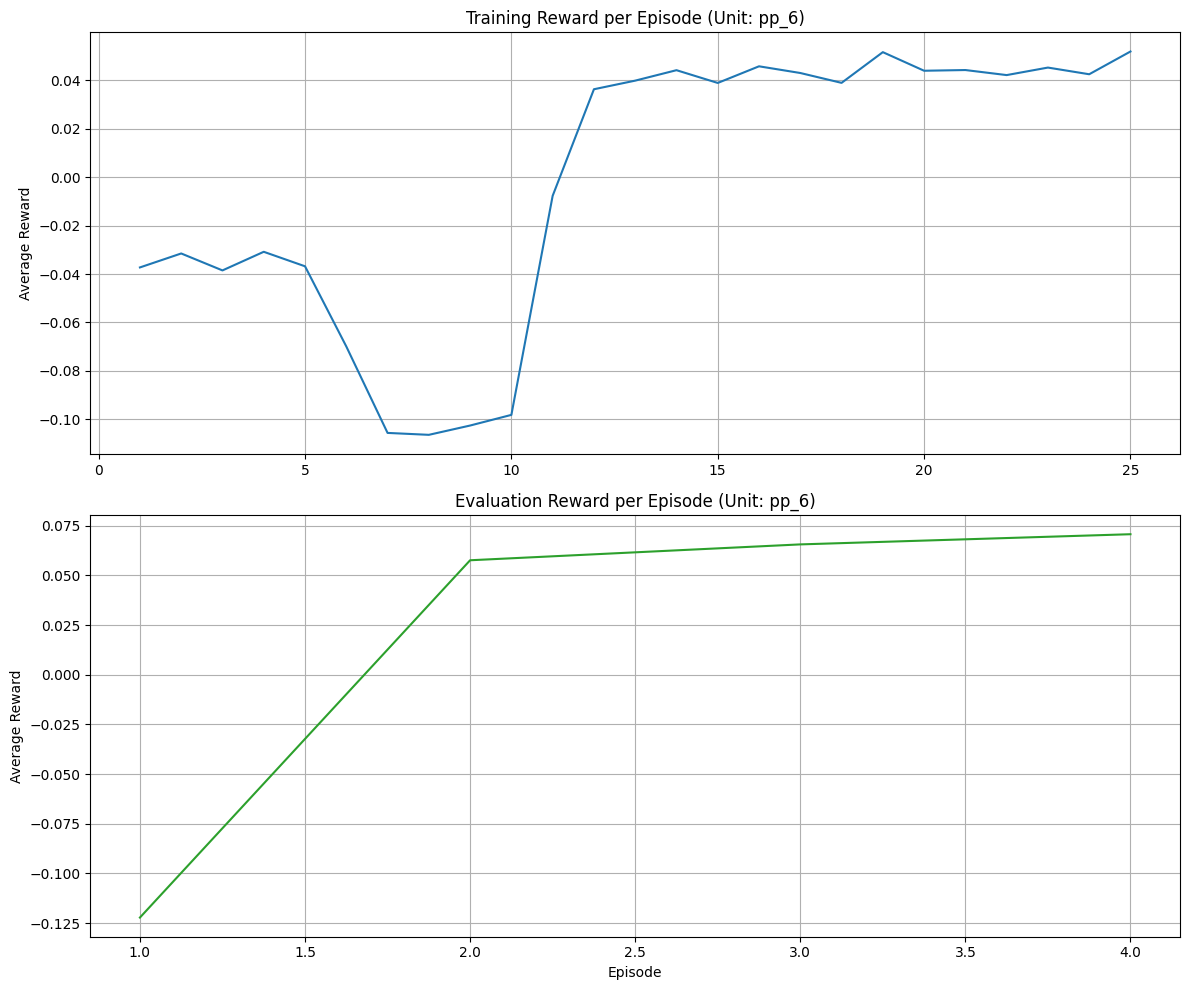

In [17]:
# Connect to the simulation database
engine = create_engine("sqlite:///local_db/assume_db.db")

# Query rewards for specific simulation and unit
sql = """
SELECT
    datetime,
    unit,
    reward,
    simulation,
    evaluation_mode,
    episode
FROM rl_params
WHERE simulation = 'example_02a_base'
  AND unit = 'pp_6'
ORDER BY datetime
"""

# Load query results
rewards_df = pd.read_sql(sql, engine)

# Rename column for consistency
rewards_df.rename(columns={"evaluation_mode": "evaluation"}, inplace=True)

# --- Separate plots for training and evaluation ---
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=False)

# Plot training rewards (evaluation == 0)
train_df = rewards_df[rewards_df["evaluation"] == 0]
train_grouped = train_df.groupby("episode")["reward"].mean()

axes[0].plot(train_grouped.index, train_grouped.values, color="tab:blue")
axes[0].set_title("Training Reward per Episode (Unit: pp_6)")
axes[0].set_ylabel("Average Reward")
axes[0].grid(True)

# Plot evaluation rewards (evaluation == 1)
eval_df = rewards_df[rewards_df["evaluation"] == 1]
eval_grouped = eval_df.groupby("episode")["reward"].mean()

axes[1].plot(eval_grouped.index, eval_grouped.values, color="tab:green")
axes[1].set_title("Evaluation Reward per Episode (Unit: pp_6)")
axes[1].set_xlabel("Episode")
axes[1].set_ylabel("Average Reward")
axes[1].grid(True)

plt.tight_layout()
plt.show()

**What This Shows**

* **Training curve**: Captures learning progress with exploration noise.
* **Evaluation curve**: Tracks the performance of the evaluation/validation run without noise, which is performed every `validation_episodes_interval` steps, as defined in the `learning_config`. 

This plot provides insight into:

* How well the agent is improving over time.
* Whether learning has converged or stagnated.


### 7.4 Summary

* You have now run your **first complete training loop** in ASSUME.
* The learning configuration defines all key training parameters—review them carefully.
* After training, rewards from `rl_params` allow you to inspect and validate agent behavior.
* The separation of **training** and **evaluation** rewards is key to understanding generalization.


In the next chapter, you may proceed to analyze simulation outcomes in greater detail (e.g., market prices, total costs, capacity dispatch), or compare different agent configurations.

---

## 8. Analyzing Strategic Bidding Behavior

Now that your agent has completed training, we shift our focus to a critical and more insightful question:

> **What did the agent actually learn?**

This chapter analyzes the **actual bids submitted by the agent** and evaluates whether the agent developed a **strategic bidding behavior**—especially in the context of market power.


### 8.1. Background: Market Setup

This simulation is based on **example case 1** from the following study:

**\[1]** Harder, N.; Qussous, R.; Weidlich, A.
*Fit for purpose: Modeling wholesale electricity markets realistically with multi-agent deep reinforcement learning*.
Energy and AI, 2023, 14:100295.
[https://doi.org/10.1016/j.egyai.2023.100295](https://doi.org/10.1016/j.egyai.2023.100295)

In this case:

* The market contains **one large RL agent**: `pp_6`.
* The agent has enough capacity to influence the market clearing price.
* It is allowed to bid freely to maximize its own reward (profit, adjusted by regret).

**Marginal Cost Structure:**

| Unit      | Marginal Cost (€/MWh) |
| --------- | --------------------- |
| pp\_6     | **55.7**              |
| Next unit | **85.7**              |

A profit-maximizing agent **with market power** would learn to bid just below the next most expensive unit—in this case, somewhere just below **85.7 €/MWh**.

### 8.2. Extract and Plot the Agent's Bids

We will extract the bids submitted by `pp_6` from the `market_orders` table and plot them over time.

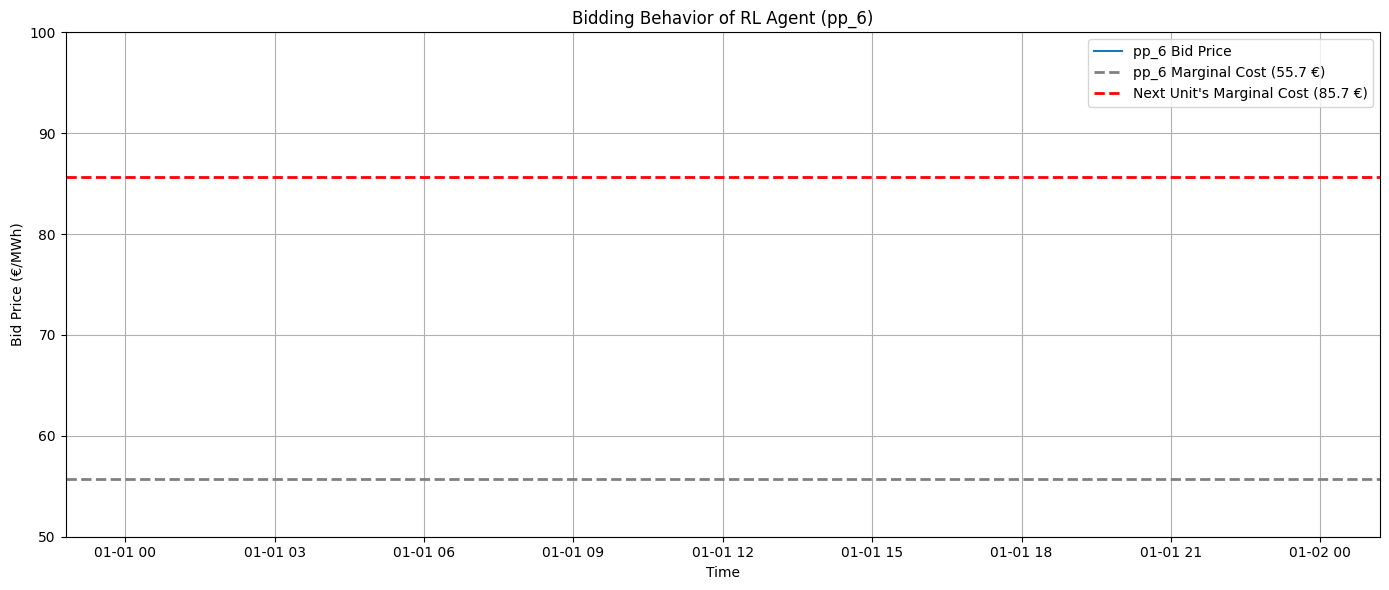

In [18]:
# Connect to database
engine = create_engine("sqlite:///local_db/assume_db.db")

# Query bids from pp_6 in simulation example_02a_base and market EOM
sql = """
SELECT
    start_time AS time,
    price,
    unit_id,
    simulation
FROM market_orders
WHERE simulation = 'example_02a_base'
  AND unit_id = 'pp_6'
  AND market_id = 'EOM'
ORDER BY start_time
"""

# Load results into DataFrame
bids_df = pd.read_sql(sql, engine)
bids_df["time"] = pd.to_datetime(bids_df["time"])

# Define marginal cost boundaries
mc_pp6 = 55.7
mc_next = 85.7

plt.figure(figsize=(14, 6))
plt.plot(bids_df["time"], bids_df["price"], label="pp_6 Bid Price", color="tab:blue")

# Reference lines for marginal cost and competitive threshold
plt.axhline(
    mc_pp6,
    color="gray",
    linestyle="--",
    linewidth=2,
    label="pp_6 Marginal Cost (55.7 €)",
)
plt.axhline(
    mc_next,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Next Unit's Marginal Cost (85.7 €)",
)

plt.title("Bidding Behavior of RL Agent (pp_6)")
plt.xlabel("Time")
plt.ylabel("Bid Price (€/MWh)")
plt.legend()
plt.ylim(50, 100)
plt.grid(True)
plt.tight_layout()
plt.show()

### 8.4. What Does This Show?

The plot typically reveals:

* The agent **almost never bids at its own marginal cost**.
* Instead, its bid prices **cluster below 85.7 €/MWh**, indicating that it has learned to:

  * Underbid the next unit to secure dispatch.
  * **Exploit its market position** to maximize profit rather than behave as a price-taker.
* This is consistent with **strategic bidding behavior** in oligopolistic market settings.

This outcome aligns with the findings from \[1], confirming that **deep RL agents can learn to exercise market power** when not explicitly restricted.

### 8.5. Summary

* The RL agent did not simply mimic marginal cost bidding—it learned to **optimize strategically**.
* The bid curve confirms that **market power was exercised** by bidding just under the next marginal unit.
* This is a core feature of realistic market modeling, and shows the value of RL in economic simulations.

---


## 9. Summary and Outlook

### 9.1. What You Built

Over the course of this tutorial, you developed a complete **RL bidding strategy** for an electricity market agent in the **ASSUME** framework. You constructed and trained a fully functional learning agent that can:

* Observe the market and its own internal state.
* Make strategic bidding decisions based on learned policy.
* Receive reward signals and adapt its behavior accordingly.
* Exploit market dynamics, including market power, when permitted.

### 9.2 What You Learned

Throughout the tutorial, you explored the **full learning pipeline** in a realistic electricity market context:

* How to construct **observations** from both global forecasts and unit-specific state.
* How to define **actions** and handle **exploration**, including guided exploration around meaningful economic baselines.
* How to design and normalize a **reward function** that balances realized profit with opportunity cost.
* How to run a simulation using **multi-agent DRL** and analyze its outcomes.
* How to evaluate **bidding behavior** and interpret **economic strategies** emerging from the agent’s learning process.


### 9.3 What You Can Try Next

Your implementation is modular and extensible. Here are several directions you can explore on your own:

1. **Adjust Learning Parameters**

Experiment with:

* `learning_rate`, `gamma`, `noise_sigma`, `episodes_collecting_initial_experience`
* `validation_episodes_interval`, `train_freq`, or `gradient_steps`

Observe how these changes affect convergence, stability, and bidding behavior.

2. **Try Different Scenarios**

* Run **`example_02b`** or **`example_02c`**:

  * `02b`: Introduces moderate competition with several learning agents.
  * `02c`: Contains many learning agents, simulating a highly competitive environment.
* Compare bidding behavior and reward dynamics across settings.

3. **Dive into other tutorials**

* If you are interested in the general algorithm behind the MADDPG and how it is integrated into ASSUME look into [04a_RL_algorithm_example](.\04a_reinforcement_learning_algorithm_example.ipynb) 
* In the samll exmaple we analysed we as modellers could see what the a good bidding behavior of the agent might be and, hence, can judge learning easly, but what if we model many agents in new simualtions? We provide explainable RL mechanisms in another tutroial for you to dive into [09_example_Sim_and_xRL](.\09_example_Sim_and_xRL.ipynb) 

